 **yolov5**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MyDrive1

/content/drive/MyDrive/MyDrive1


In [ ]:
#clone YOLOv5
#yolov5 folder create

!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="ultralytics")

In [ ]:
# set up environment
#datsets folder create
os.environ["DATASET_DIRECTORY"] = "/content/drive/MyDrive/MyDrive1/datasets"

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="userownkey")
project = rf.workspace("  ").project("    ")
dataset = project.version(2).download("yolov5")

In [ ]:
%cd /content/drive/MyDrive/MyDrive1/yolov5

[Errno 2] No such file or directory: '/content/drive/MyDrive/MyDrive1/yolov5'
/content


In [ ]:
#training our custom model

!python train.py --img 416 --batch 16 --epochs 500 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

In [ ]:
#run inference

!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source {dataset.location}/test/images

In [ ]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/drive/MyDrive/MyDrive1/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
#export your model's weights for future use

from google.colab import files
files.download('./runs/train/exp/weights/best.pt')

In [ ]:
#show result

import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'custom', '/content/drive/MyDrive/MyDrive1/yolov5/runs/train/exp/weights/best.pt')


# Images
img = '/content/drive/MyDrive/MyDrive1/ramenTest.jpg'  # or file, Path, PIL, OpenCV, numpy, list

# Inference
results = model(img)

# Results
results.show()
results.print()
results.crop()
  # or .show(), .save(), .crop(), .pandas(), print()

**resnet**


In [ ]:
#dataset split(train, test, valid)

!pip install split-folders
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/MyDrive1/resnetDataset',output ='/content/drive/MyDrive/MyDrive1/resnetDatasetSplit',seed=77, ratio=(0.9,0.05,0.05) )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 40 files [00:16,  2.36 files/s]


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [ ]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [ ]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/drive/MyDrive/MyDrive1/resnetDatasetSplit'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 35
테스트 데이터셋 크기: 5
클래스: ['Bibim', 'Japageti', 'nuguri', 'snack']


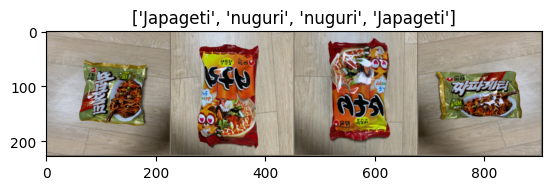

In [ ]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
#model loading

model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 265MB/s]


In [ ]:
# training our model

num_epochs = 100
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

In [ ]:
# Save model
torch.save(model, '/content/drive/MyDrive/MyDrive1/resnetBest.pt')


In [ ]:
# Load model
model = torch.load('/content/drive/MyDrive/MyDrive1/resnetBest.pt')
model.eval()

In [ ]:
# show result

model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[predication: {class_names[preds[0]]}] (answer: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='predication: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

**웹페이지/app.py/ngrok배포**
